In [5]:
import sys
import os
import random
import json
import gc
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score
from functools import partial
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from tensorflow import keras

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset


from torchvision import transforms

In [83]:
## Configurations
class CFG:
    resnext = 'resnext50_32x4d'
    n_class = 5
    trn_fold = [1,2,3,4,5]
    data_dir = './data/test_images'
    batch_size = 8
    deit = 'deit_base_patch16_384'
    img_size = (512,512)

In [177]:
image_size = (512,512)
submission = pd.DataFrame(columns={"image_id","label"})
submission["image_id"] = os.listdir(CFG.data_dir)
submission["label"] = 0

Used Models in the final submission

In [110]:
# We used this flag to test combinations using only TF.Keras models

# h5 파일은 HDF5 포멧으로 저장된 파일
# ckpt 확장자는 tensorflow, pt와 pth는 pytorch에서 사용되는 확장자
# pb 파일은 ckpt 파일과는 달리 모델 구조와 가중치 값이 합쳐진 파일이다. 그래서 재학습이 불가능

onlykeras = False
        
used_models_pytorch = {"efficientnet": [f'./checkpoint/Efficientnet/f{fold}.pth' for fold in CFG.trn_fold],
                       "resnext": [f'./checkpoint/Resnext50/f{fold}.pth' for fold in CFG.trn_fold],
                       "deit": [f'./checkpoint/Deit/f{fold}.pth' for fold in CFG.trn_fold]
                      }

used_models_keras = {"Cropnet": "./checkpoint/Cropnet"}

# We used this flag for testing different ensembling approaches
stacked_mean = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
# util
def load(model_path, net):
    dict_model = torch.load(model_path)
    net.load_state_dict(dict_model)
    return net

ResNext50_32x4d

In [ ]:
# dataset 클래스는 공통으로 사용할 수 있다.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

        self.arr_input = df['image_id'].values

    def __len__(self):
        return len(self.arr_input)

    def __getitem__(self, index):
        input = cv2.imread(os.path.join(self.data_dir, self.arr_input[index]), cv2.IMREAD_COLOR)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)  # result of input shape is y,x,c

        if self.transform:
            input = self.transform(image=input)['image']

        data = {'input' : input}

        return data

In [11]:
# 예전에는 네트워크에 어떤 모델 이름이든 들어갈 수 있도록 했지만
# 이번에는 네트워크를 동시에 선언할 것이기 때문에 이름을 정해준다.
# 마찬가지로 n_class도 몇개인지 정해준다.

class Resnext(nn.Module):
    def __init__(self, network=CFG.resnext, n_class=CFG.n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(network, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
if "Resnext" in used_models_pytorch:
    # 각각 모델마다 Augmentation 방법이 다르니 if 문 안에 써주는게 맞다.
    # 나는 validation할때 항상 centercrop했는데 1등 솔루션은 리사이즈함
    def transform_test():
        return A.Compose([A.Resize(512, 512),
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()])

    
    # 다음부터 정리하게 된다면 용어 하나만 필요하면 첫번째로 net 쓰고 두개필요하면 net, model 사용하기
    # 그리고 첫번째는 input, output 두개필요하면 pred
    def inference(models, loader_test, device):
        prob = [] 
        for batch, data in enumerate(loader_test, 1):
            input = data['input'].to(device)
            avg_output = []
            
            # 5개의 split 모델이 계산한 값들을 평균내야 하기 때문에 batch for문 다음 states for문을 쓰는게 맞다.
            for model in models:
                model.eval()
                with torch.no_grad():
                    output = model(input)
                avg_output.append(output.softmax(1).to('cpu').numpy())
            avg_output = np.mean(avg_output, axis=0)
            prob.append(avg_output)
        return np.concatenate(prob)   # 이건 아마 배치마다 []로 묶이니까 풀어주기 위해 한듯
    
    
    # inference
    net = Resnext(CFG.resnext, CFG.n_class, pretrained=False).to(device)   # 나는 pretrained=True 했는데 False가 맞나봄
    # states는 모델들이다.
    # used_models_pytorch에 Resnext가 있으면 load 함수를 통해 하나씩 로드한다.
    # load 함수는 model path와 net을 인자로 받는다.
    models = [load(f, net) for f in used_models_pytorch["Resnext"]]

    dataset_test = Dataset(df=submission, data_dir=CFG.data_dir, transform=transform_test())
    loader_test = DataLoader(dataset_test, batch_size=CFG.batch_size, shuffle=False, num_workers=8, pin_memory=True) 
    
    # 아직 argmax를 하지 않았기 때문에 probability인 상태이다.
    prob = inference(loader_test, net, device)

    
    # submission save
    predictions_resnext = pd.DataFrame(columns={"image_id"})
    predictions_resnext["image_id"] = submission["image_id"].values
    predictions_resnext['image_path_id'] = CFG.data_dir + predictions_resnext['image_id'].astype(str)

    predictions_resnext['resnext'] = [np.squeeze(p) for p in predictions]
    predictions_resnext = predictions_resnext.drop(["image_path_id"], axis=1)
    

    # empty_cache() 를 통해 사용하지 않으면서 캐시된 메모리들을 해제할 수 있다.
    torch.cuda.empty_cache()
    try:
        del(model)
        del(states)
    except:
        pass
    gc.collect()

Deit

In [ ]:
class Deit(nn.Module):
    def __init__(self, network, n_class, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', network, pretrained=pretrained)
        self.n_features = self.model.head.in_features
        self.model.head = nn.Linear(self.n_features,n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
if "Deit" in used_models_pytorch:    
    def transform_test():
        return A.Compose([A.CenterCrop(384, 384, p=1.),
                A.Resize(384, 384),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0)], p=1.)

    def inference(models, loader_test, device):
        prob = [] 
        for batch, data in enumerate(loader_test, 1):
            input = data['input'].to(device)
            avg_output = []            
            
            for model in models:
                model.eval()
                
                with torch.no_grad():
                    output = model(input)
                avg_output.append(output.softmax(1).to('cpu').numpy())
                
            avg_output = np.mean(avg_output, axis=0)
            prob.append(avg_output)
            
        return np.concatenate(prob)    
    
    # inference
    net = Deit(CFG.deit, CFG.n_class, pretrained=False).to(device)   
    models = [load(f, net) for f in used_models_pytorch["Deit"]]

    dataset_test = Dataset(df=submission, data_dir=CFG.data_dir, transform=transform_test())
    loader_test = DataLoader(dataset_test, batch_size=CFG.batch_size, shuffle=False, num_workers=8, pin_memory=True) 
    
    # 아직 argmax를 하지 않았기 때문에 probability인 상태이다.
    prob = inference(loader_test, net, device)

    
    # submission save
    predictions_vit = pd.DataFrame(columns={"image_id"})
    predictions_vit["image_id"] = submission["image_id"].values
    predictions_vit['image_path_id'] = CFG.data_dir + predictions_vit['image_id'].astype(str)

    predictions_vit['deit'] = [np.squeeze(p) for p in predictions]
    predictions_vit = predictions_vit.drop(["image_path_id"], axis=1)
    
    
    torch.cuda.empty_cache()
    try:
        for model in models:
            del(model)
    except:
        pass
    models = []
    gc.collect()

Efficientnet

In [165]:
import timm

import torch
import torch.nn as nn

##
class Efficientnet(nn.Module):
    def __init__(self, network, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(network, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)

        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
if "Efficientnet" in used_models_pytorch:  
    
'''
코드가 케라스로 만들어져서 입력이 [10, 512, 512, 3]으로 한 장의 이미지를 10장으로 어그멘테이션한걸 넣게 되어 있는데
내꺼 저장모델은 파이토치라서 파이토치 버전으로 바꾸려면 꽤 골치 아파짐...
일단 토치는 한개 인풋을 받게 되어 있어서 좀 수정할 게 많음... 일단 패스...
만약 구현한다 싶으면 tta하듯 for i in range(10):  input[i, :, :, :] 결과 ++++ 평균 이렇게 해야하나...


    def image_augmentations(image):
        p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

        if p_spatial > 0.75:
            image = tf.image.transpose(image)

        if p_rotate > 0.75:
            image = tf.image.rot90(image, k = 3)
        elif p_rotate > 0.5:
            image = tf.image.rot90(image, k = 2)
        elif p_rotate > 0.25:
            image = tf.image.rot90(image, k = 1)

        image = tf.image.resize(image, size = CFG.img_size)
        image = tf.reshape(image, [*CFG.img_size, 3]) # *가 꼭 들어가야 오류가 안난다

        return image

    def read_preprocess_file(img_path, normalize=False):
        image = Image.open(img_path)
        if normalize:
            img_scaled = np.array(image)/ 255.0
        else:
            img_scaled = np.array(image)
        img_scaled = img_scaled.astype(np.float32)
        return (image.size[0], image.size[1]), img_scaled # 그럼 리턴값이 (현재 저장된 이미지 크기*크기), 이미지 밸류?

    
    def create_image_tiles(origin_dim, processed_img): # 아래 코드보면 read_preprocess_file 리턴값이 들어감
        crop_size = 512
        img_list = []
        for x in [0, origin_dim[1] - crop_size]:
            for y in [0, origin_dim[0] - crop_size]:
                img_list.append(processed_img[x:x+crop_size , y:y+crop_size,:])
        img_list.append(cv2.resize(processed_img[:, 100:700 ,:], dsize=(crop_size, crop_size)))
        return np.array(img_list)

    def augment_tiles_light(tiles, ttas=2): 
        holdout = np.broadcast_to(tiles[-1,:,:,:],(ttas,) + tiles.shape[1:])
        augmented_batch = tf.map_fn(lambda x: image_augmentations(x), tf.concat([tiles[:-1,:,:,:] for _ in range(ttas)], axis=0))
        return tf.concat([augmented_batch, holdout], axis=0) 
        
    
    
    def transform_test():
        return augment_tiles_light(create_image_tiles(*read_preprocess_file(img_path)))

    def inference(models, loader_test, device):
        prob = [] 
        for batch, data in enumerate(loader_test, 1):
            input = data['input'].to(device)
            avg_output = []            
            
            for model in models:
                model.eval()
                
                with torch.no_grad():
                    output = model(input)
                avg_output.append(output.softmax(1).to('cpu').numpy())
                
            avg_output = np.mean(avg_output, axis=0)
            prob.append(avg_output)
            
        return np.concatenate(prob)    
    
    # inference
    net = Deit(CFG.deit, CFG.n_class, pretrained=False).to(device)   
    models = [load(f, net) for f in used_models_pytorch["Deit"]]

    dataset_test = Dataset(df=submission, data_dir=CFG.data_dir, transform=transform_test())
    loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8, pin_memory=True) 
    
    # 아직 argmax를 하지 않았기 때문에 probability인 상태이다.
    prob = inference(loader_test, net, device)

    
    # submission save
    predictions_vit = pd.DataFrame(columns={"image_id"})
    predictions_vit["image_id"] = submission["image_id"].values
    predictions_vit['image_path_id'] = CFG.data_dir + predictions_vit['image_id'].astype(str)

    predictions_vit['deit'] = [np.squeeze(p) for p in predictions]
    predictions_vit = predictions_vit.drop(["image_path_id"], axis=1)
    
    
    torch.cuda.empty_cache()
    try:
        for model in models:
            del(model)
    except:
        pass
    models = []
    gc.collect()

In [22]:
# weight가 들어있는 모델을 다운
# !curl -LO https://storage.googleapis.com/tfhub-modules/google/cropnet/classifier/cassava_disease_V1/2.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.1M  100 15.1M    0     0  8756k      0  0:00:01  0:00:01 --:--:-- 8756k


In [23]:
# !mkdir cropnet_mobilenetv3

In [24]:
# tar 파일을 압축해제 하는 명령어 인듯
# !tar -xf 2.tar.gz  --directory cropnet_mobilenetv3   

In [114]:
import tensorflow_hub as hub

In [115]:
os.environ["TFHUB_CACHE_DIR"] = "./"

In [116]:
'''
인터넷이 연결되는 경우는 아래와 같은 코드를 사용해서 하는 것으로 보임 
classifier = hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2')

hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2', trainable=False)
'''

"\n인터넷이 연결되는 경우는 아래와 같은 코드를 사용해서 하는 것으로 보임 \nclassifier = hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2')\n\nhub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2', trainable=False)\n"

In [117]:
def build_mobilenet3(img_size=(224,224), weights="./checkpoint/Cropnet"):
    classifier = hub.KerasLayer(weights)
    model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=img_size + (3,)), # input shape= 224,224,3 
                                 hub.KerasLayer(classifier, trainable=False)])
    return model

In [ ]:
# 함수가 엮여 있어 리턴값을 확인하기 어려우므로 하나씩 보자

In [85]:
def image_augmentations(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > 0.75:
        image = tf.image.transpose(image)
        
    if p_rotate > 0.75:
        image = tf.image.rot90(image, k = 3)
    elif p_rotate > 0.5:
        image = tf.image.rot90(image, k = 2)
    elif p_rotate > 0.25:
        image = tf.image.rot90(image, k = 1)

    image = tf.image.resize(image, size = CFG.img_size)
    image = tf.reshape(image, [*CFG.img_size, 3]) # *가 꼭 들어가야 오류가 안난다
    
    return image

In [22]:
def read_preprocess_file(img_path, normalize=False):
    image = Image.open(img_path)
    if normalize:
        img_scaled = np.array(image)/ 255.0
    else:
        img_scaled = np.array(image)
    img_scaled = img_scaled.astype(np.float32)
    print(image)
    return (image.size[0], image.size[1]), img_scaled # 그럼 리턴값이 (현재 저장된 이미지 크기*크기), 이미지 밸류?

In [23]:
# 예시
img_path = './data/test_images/2216849948.jpg'

result = read_preprocess_file(img_path=img_path, normalize=True)
result

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7FAAE334D610>


((800, 600),
 array([[[0.5137255 , 0.49019608, 0.39607844],
         [0.5254902 , 0.5176471 , 0.41960785],
         [0.5803922 , 0.59607846, 0.49019608],
         ...,
         [0.6156863 , 0.7294118 , 0.5019608 ],
         [0.4       , 0.5019608 , 0.31764707],
         [0.26666668, 0.3647059 , 0.21176471]],
 
        [[0.5568628 , 0.5372549 , 0.45882353],
         [0.54509807, 0.5372549 , 0.45490196],
         [0.5568628 , 0.57254905, 0.48235294],
         ...,
         [0.62352943, 0.73333335, 0.5058824 ],
         [0.43529412, 0.5254902 , 0.3529412 ],
         [0.30588236, 0.39215687, 0.24313726]],
 
        [[0.5411765 , 0.5294118 , 0.47058824],
         [0.5137255 , 0.5176471 , 0.45490196],
         [0.49803922, 0.5137255 , 0.44705883],
         ...,
         [0.69803923, 0.7882353 , 0.5764706 ],
         [0.61960787, 0.6901961 , 0.5254902 ],
         [0.56078434, 0.627451  , 0.4862745 ]],
 
        ...,
 
        [[0.12156863, 0.19607843, 0.17254902],
         [0.1254902 , 0.2   

In [42]:
# 저장된 이미지의 크기가 800이라면 512 사이즈로 크롭해서 패치를 만든다.
# 입력 인자가 origin_dim, processed_img인걸 보아선 위에 프로세싱된 리턴값을 그대로 받는 듯 하다.
def create_image_tiles(origin_dim, processed_img): # 아래 코드보면 read_preprocess_file 리턴값이 들어감
    crop_size = 512
    img_list = []
    # Cut image into 4 overlapping patches
    # 원본 이미지 사이즈가 800이라면 for x in [0, 288]이 되고, 원점 xy좌표가 0,0 / 0, 288 / 288,0 / 288,288인 곳에서 크롭이 된다.
    for x in [0, origin_dim[1] - crop_size]:
        for y in [0, origin_dim[0] - crop_size]:
            img_list.append(processed_img[x:x+crop_size , y:y+crop_size,:])
    # Keep one additional center cropped image 
    # 센터 크롭 이미지 2개까지 5개 패치를 만드나 보다. 
    # 100:700이 좀 특이한데 지금 현재 사진이 800by600이니까 먼저 600by600 정방형 사진을 만든후 512, 512로 리사이즈 하는 과정이네
    # 그냥 512, 512을 센터크롭해버리면 약간 사진정보가 훼손 될텐데 이방법은 자르고 리사이즈해서 훼손과 정보 유지를 동시에 타협한듯
    # 아마 가장 마지막 자리에 들어가는 사진이 센터크롭인듯
    img_list.append(cv2.resize(processed_img[:, 100:700 ,:], dsize=(crop_size, crop_size)))
    return np.array(img_list)


In [64]:
# 예시2
img_path = './data/test_images/2216849948.jpg'

result2 = create_image_tiles(*read_preprocess_file(img_path=img_path, normalize=False))
# result2.shape # 512, 512 이미지를 가진 5개의 패치인듯 (5, 512, 512, 3)
result2.shape

(5, 512, 512, 3)

In [63]:
import matplotlib.pyplot as plt

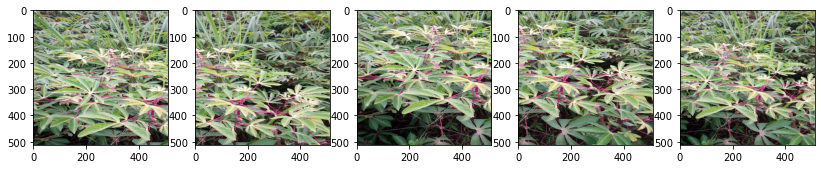

In [67]:
fig = plt.figure(figsize = (14, 7))
for i in range(5):
    plt.subplot(1, 5,i+1)
    plt.imshow((result2[i, : , :, :]).astype(np.uint8)) # tlqkf 또 매직키워드, 0~1로 클립핑되는 건 plt 특징인 것같다. 유니트로 변환할것

# result3 = np.squeeze(result2[1, :, :, :])
plt.show()

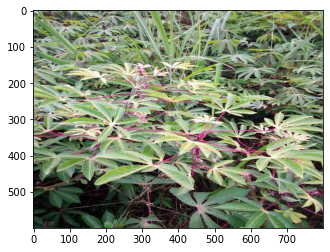

In [69]:
# 비교를 위한 원본이미지

img_dir = './data/test_images/2216849948.jpg'

img = cv2.imread(img_dir, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [70]:
result2.shape

(5, 512, 512, 3)

In [73]:
holdout = np.broadcast_to(result2[-1,:,:,:],(2,) + result2.shape[1:])
holdout.shape

(2, 512, 512, 3)

In [75]:
(2,) + result2.shape[1:]

(2, 512, 512, 3)

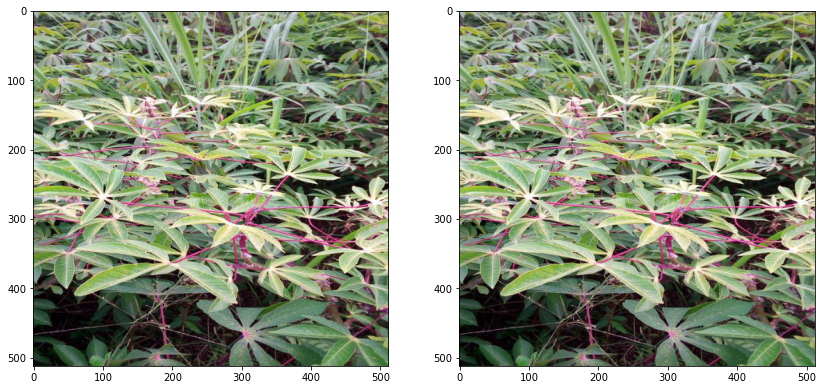

In [74]:
fig = plt.figure(figsize = (14, 7))
for i in range(2):
    plt.subplot(1, 2,i+1)
    plt.imshow((holdout[i, : , :, :]).astype(np.uint8)) # tlqkf 또 매직키워드, 0~1로 클립핑되는 건 plt 특징인 것같다. 유니트로 변환할것

# result3 = np.squeeze(result2[1, :, :, :])
plt.show()

In [ ]:
'''
https://numpy.org/doc/stable/reference/generated/numpy.broadcast_to.html

>>> x = np.array([1, 2, 3])
>>> np.broadcast_to(x, (3, 3))
array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])
'''

In [77]:
def augment_tiles_light(tiles, ttas=2): # tiles에는 create_image_tiles 리턴값인 (5, 512, 512, 3)가 들어온다.
  # Copy central croped image to have same ratio to augmented images
    # (2,) + result2.shape[1:] 의 결과값은 (2, 512, 512, 3)으로 (1, 512, 512, 3)에서 1을 2로 만들어주는 건데 그냥 복사가 된다.
    holdout = np.broadcast_to(tiles[-1,:,:,:],(ttas,) + tiles.shape[1:])
    
    # map_fn은 앞에 함수를 쓰고 뒤에 인자를 써서 실행시켰던 함수 였던 것같다. 그니까 lambda에 뒤에 x가 들어감.
    # Transforms elems by applying fn to each element unstacked on axis 0.
    # tf.map_fn(fn, elems)
    
    augmented_batch = tf.map_fn(lambda x: image_augmentations(x), np.concat([tiles[:-1,:,:,:] for _ in range(ttas)], axis=0))
    
    # tf.concat([tiles[:-1,:,:,:] for _ in range(ttas)] 를 통해 4장짜리 사진을 8장으로 만들어서 각각 어그멘테이션 한 것 같다. 그후 센터 크롭한사진과 합침
    # 이래서 같은 비율을 맞추기 위해 증가시켯다고 한듯
    
    return tf.concat([augmented_batch, holdout], axis=0) # axis=0은 행으로 붙이기 1은 열로 붙이기


In [86]:
result3 = augment_tiles_light(result2, ttas=2)
result3.shape

TensorShape([10, 512, 512, 3])

In [100]:
# 위에서 작업한 내용은 EfficientNet을 위한 거였고 이 함수는 CropNet을 위한 것
# Cropnet에서는 기본 이미지 사이즈를 224, 224를 받는다. 0.8 비율로 센터 크롭한후 224로 축소한듯

# read_preprocess_file(img_path, True)[1]의 값이 processed_img로 들어가는데 read preprocess 의 리턴값은
# (800, 600), image value지만 리스트 [1]을 이용해서 이미지 값만 들어감

def cut_crop_image(processed_img):
    image = tf.image.central_crop(processed_img, 0.8)
    image = tf.image.resize(image, (224, 224))
    return np.expand_dims(image, 0)    # 만약 np.expand_dims하지 않으면 TensorShape([224, 224, 3])의 shape가 나온다.

# np.expand_dims를하면 (1, 224, 224, 3)이 나온다. np.expand_dims(image, -1)을하면 (224, 224, 3, 1). 숫자 0, 1 이 디멘션 위치네.

In [101]:
result4 = cut_crop_image(result[1])
result4.shape

(1, 224, 224, 3)

In [145]:
# CropNet class 6 (unknown) is distributed evenly over all 5 classes to match problem setting

# 텐서플로우 허브에서 제공하는 크롭넷은 6가지로 분류하게 되어있기 때문에 이를 수정한다.
# propabilities[:,:-1]으로 먼저 5개의 클래스 확률 값을 살리고 
# 6번째 클래스 값은 5로 나누어서(propabilities[:,-1]/5) 각각 그값을 5개의 클래스에 더한다. 
# brodcast연산할대 디멘션을 맞춰주기 위해 np.expand_dims를 한다.
def distribute_unknown(propabilities):
    return propabilities[:,:-1] + np.expand_dims(propabilities[:,-1]/5, 1) 


# 이미지를 배치사이즈가 아닌 그냥 한장씩 입력해서 하는듯 케라스라서 가능한가?
# 결과값을 np.mean 하는 이유는 같은 이미지를 어그멘테이션 해서 여러장을 만들었기 때문에 각각 이미지에 대한 결과값을 평균 앙상블 하는 것
#  (한번 입력할때마다 한장의 이미지지만 여러개의 같은 이미지가 들어감_)

def multi_predict_tfhublayer(img_path, modelinstance):
    # 여기서 하단의 True는 normalize에 대한 인자로 normalize 하겠다는 의미
    img = cut_crop_image(read_preprocess_file(img_path, True)[1])
    yhat = modelinstance.predict(img)
    return np.mean(distribute_unknown(yhat), axis=0)

# 이건 efficientnet 용인듯
# modelinstance는 모델 그자체를 의미 그러니까 여기선 이피션트넷
def multi_predict_keras(img_path, modelinstance, *args):
    augmented_batch = augment_tiles_light(create_image_tiles(*read_preprocess_file(img_path)))
    Yhat = modelinstance(augmented_batch)
    return np.mean(Yhat, axis=0)



def predict_and_vote(image_list, modelinstances, onlykeras):
    predictions = [] 
    with tqdm(total=len(image_list)) as process_bar:       
        for img_path in image_list:
            process_bar.update(1)  
        # modelinstances는 multi_predict_XXXX 함수와 model_XXXX로 구성된 리스트이다. (모델인스턴스 뒤에 에스 들어가있음)
        # func가 multi_predict_XXXX가 되고 modelinstance가 model_XXXX가 된다.
        # 원래 multi_predict_XXXX에는 image_path와 *modelinstance(즉, 모델 그자체)*를 받기 때문에 말이 된다.
        # 각 모델의 결과를 vstack으로 쌓기 때문에 한 라벨 예측값 =[[첫번째 모델 예측값], [두번째 모델 에측값]..]이 나온다.
        # 뒤에서 explode해서 나눠준다. (그냥 두번하지..)
            Yhats = np.vstack([func(img_path, modelinstance) for func, modelinstance in modelinstances])
            print(Yhats)
        
        # onlykeras = False 해당구문 실행 안됨. 아마 결과값(predictions)은 확률값으로 나올듯 하긴 그래야 파이토치로 구현한 레즈넷등이랑 앙상블함
        if onlykeras:
            predictions.append(np.argmax(np.sum(Yhats, axis=0)))
        else:
            predictions.append(Yhats)    
    return predictions

In [189]:
# 위 함수들은 엮여 있어서 공부하려면 여기서부터 보는게 좋겠다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference_models = []

if "Cropnet" in used_models_keras:   
    model_mobilenet = build_mobilenet3(weights=used_models_keras["Cropnet"])    # 크롭넷 모델 정의
    inference_models.append((multi_predict_tfhublayer, model_mobilenet))    # inference_models라는 리스트에는 함수와 모델이 들어감. 함수자체가 들어가기 때문에 굳이 인자는 안써주는듯
    
# if "Efficientnet" in used_models_pytorch:
#     model_efficientnetb4 = Efficientnet('tf_efficientnet_b4_ns', CFG.n_class, pretrained=True).to(device)
#     # model_efficientnetb4 =  keras.models.load_model(used_models_keras["Efficientnet"], compile=False)
#     inference_models.append((multi_predict_keras, model_efficientnetb4))
    
# 내가 사용하지 않은 모델
# if "efficientnetb5" in used_models_keras:
#     model_efficientnetb5 =  keras.models.load_model(used_models_keras["efficientnetb5"])
#     inference_models.append((multi_predict_keras, model_efficientnetb5))


#inference_models

# onlykras = False
# stacked_mean = True
# [image_path+id for id in submission_df["image_id"].values] 는 모든 이미지 데이터의 경로가 리스트로 저장된 변수 (image_list)
submission["label"] = predict_and_vote([os.path.join(CFG.data_dir, id) for id in submission["image_id"].values], inference_models, onlykeras)

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

[[0.00399159 0.00370761 0.8709404  0.00654031 0.11482014]]


In [131]:
[os.path.join(CFG.data_dir, id) for id in submission["image_id"].values]

['./data/test_images/2216849948.jpg']

In [152]:
a=[[3.9909426e-03, 3.7069598e-03, 8.7093973e-01, 6.5396614e-03, 1.1481949e-01, 3.2432399e-06]]
a=np.array(a)
a

array([[3.9909426e-03, 3.7069598e-03, 8.7093973e-01, 6.5396614e-03,
        1.1481949e-01, 3.2432399e-06]])

In [153]:
def distribute_unknown(propabilities):
    return propabilities[:,:-1] + np.expand_dims(propabilities[:,-1]/5, 1) # 언노운 클래스인 -1 (마지막)꺼 빼고 

In [154]:
abc = distribute_unknown(a)

In [155]:
abc

array([[0.00399159, 0.00370761, 0.87094038, 0.00654031, 0.11482014]])

In [164]:
a[:, :-1]

array([[0.00399094, 0.00370696, 0.87093973, 0.00653966, 0.11481949]])

In [162]:
a[:,-1]/5

array([6.4864798e-07])

In [163]:
np.expand_dims(a[:,-1]/5, 1)

array([[6.4864798e-07]])

In [190]:
submission

,image_id,label,Cropnet
0,2216849948.jpg,"[[0.0039915913, 0.0037076084, 0.8709404, 0.006...",NaN


In [170]:
list(used_models_keras.keys())

['Cropnet']

In [186]:
list(used_models_keras)[0]

'Cropnet'

In [191]:
submission.loc[:,'Cropnet'] = submission["label"].explode()
submission

,image_id,label,Cropnet
0,2216849948.jpg,"[[0.0039915913, 0.0037076084, 0.8709404, 0.006...","[0.0039915913, 0.0037076084, 0.8709404, 0.0065..."


In [ ]:
if len(list(used_models_keras.keys())) <= 1:    
       # keras model을 하나만 사용한 경우 explode를 써서 저렇게 리스트를 벗겨낼수잇네..
    # 원래 라벨에 [[]] 형태로 있던 걸 [] 형태로 explode 시켜서 Cropnet으로 옮겼다. 
    submission_df.loc[:,list(used_models_keras)[0]] = submission_df["label"].explode()
else:
    # 케라스 모델을 2개를 사용한 경우
    # transform은 grouby 처럼 값을 받아서 함수에 apply시켜주는 것같은데 (apply랑 비슷)
    # submission label의 값을 받아서 [[리스트1], [리스트2]]를 만든후 set_axis를 통해서 각각의 이름으로 열을 만들어 주는 것같다.
    # apply에서는 보통 lambda와 같이 써서 x값을 받는다. 아래 참고
    tmp = (submission_df['label'].transform([lambda x:x[0], lambda x:x[1]]).set_axis(list(used_models_keras.keys()), axis=1, inplace=False))
    submission_df = submission_df.merge(tmp, right_index=True, left_index=True)
    
submission_df["label"] = 0

if "resnext" in used_models_pytorch:
    submission_df = submission_df.merge(predictions_resnext, on="image_id")
    
if "efficientnetb3" in used_models_pytorch:
    submission_df = submission_df.merge(predictions_cutmix, on="image_id")
    
if "vit2020" in used_models_pytorch:
    submission_df = submission_df.merge(predictions_vit, on="image_id")
    
if "vit2019" in used_models_pytorch:
    submission_df = submission_df.merge(predictions_vit2019, on="image_id")

In [ ]:
if stacked_mean:
    # zip 함수는 값을 받아 새로운 배열을 만든다. vit와 resnext를 받아서 e = (vit, resnext)이란 zip 데이터  타입을 만들어 평균함
    # 매친놈이 lambda x로 안쓰고 row로 쓰니까 졸라 복잡해보인다.
    submission_df["stage_1"] = submission_df.apply(lambda x: [np.mean(e) for e in zip(x["vit2020"], x["resnext"])], axis=1)
    # stage1은 vit와 resnext를 평균취해서 새로운 확률을 만들고
    # stage1과 cropnet, efficientnet 값을 모두 더한후 argmax 취해서 가장 큰 값을 라벨로 얻는다.
    submission_df["label"] = submission_df.apply(lambda row: np.argmax(
        [np.sum(e) for e in zip(row["mobilenet"],row["stage_1"], row["efficientnetb4"])]), axis=1)        
else:
    submission_df["label"] = submission_df.apply(lambda row: np.argmax(
        [np.sum(e) for e in zip(*[row[m] for m in list(used_models_pytorch.keys())+list(used_models_keras.keys())])]), axis=1)

In [ ]:
submission_df.head(1)

In [ ]:
submission_df[["image_id","label"]].to_csv("submission.csv", index=False)
!head submission.csv